In [77]:
import os
import pandas as pd
import numpy as np
import re
import nltk
import time
import seaborn as sns
import matplotlib.pyplot as plt

from tabulate import tabulate
from collections import Counter
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

st = False

In [78]:
def load_data():
    print('Source: https://www.kaggle.com/mrisdal/fake-news')
    return pd.read_csv("data/fake.csv")


In [79]:
def summarize_data(input_df):
    print('Starting data analysis')

    print('dataset shape is')
    print(input_df.shape)
    
    print('Columns Summary \n')

    cols = []
    for col in df.columns: 
        cols.append([ col, df[ col ].dtypes])

    print(tabulate(cols, headers = [ 'column name', 'data type' ]))
    
    print('Column "type" value distribution\n')

    vcp_type = df[ 'type' ].value_counts(normalize=True).to_frame('pct')
    print(vcp_type)
    print(vcp_type.plot.pie(y='pct', figsize=(7, 7)))
    
    print('Column "language" value distribution\n')

    vcp_language = df[ 'language' ].value_counts(normalize=True).to_frame('pct')
    print(vcp_language)
    print(vcp_language.plot.pie(y='pct', figsize=(7, 7)))
    
    

In [80]:
def strip_lang(df, lang, plot=False):
    print('Start data cleaning')
    print('Selecting '+lang+'\n')
    df = df[df.language == lang]


    if plot:
        print('Column "language" value distribution english selection\n')
        vcp = df[ 'language' ].value_counts(normalize=True).to_frame('pct')
        print(vcp)
        print(vcp.plot.pie(y='pct', figsize=(7, 7)))
    
    return df

In [81]:
def getCleanData(df, force=False):
    # NOTICE: This takes several mins to run due to fillna
    
    print('Getting cleaned data')
    if not os.path.exists("caches/cleaned.csv") or force:
        print("start the cleaning process")
        
        print("Removing non-english records")
        df = df[df.language == 'english']
        
        cdf = pd.DataFrame()

        print("Fill missing values")
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        df.select_dtypes(include=numerics).fillna(df.mean())
        stop = stopwords.words('english')

        cdf['title'] = df['title'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))
        cdf['author'] = df['author'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))
        cdf['text'] = df['text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))
        cdf['titles_word_len'] = cdf.apply(lambda row: len(nltk.word_tokenize(row['title'])), axis=1)
        cdf['author_word_len'] = cdf.apply(lambda row: len(nltk.word_tokenize(row['author'])), axis=1)
        cdf['text_word_len'] = cdf.apply(lambda row: len(nltk.word_tokenize(row['text'])), axis=1)

        cdf['ord_in_thread'] = df['ord_in_thread']
        cdf['spam_score'] = df['spam_score']
        cdf['replies_count'] = df['replies_count']
        cdf['participants_count'] = df['participants_count']
        cdf['likes'] = df['likes']
        cdf['comments'] = df['comments']
        cdf['shares'] = df['shares']
        cdf['country'] = df['country'].map(lambda x: list(df['country'].unique()).index(x))
        cdf['domain_rank'] = df['domain_rank'].fillna(0)
        cdf['site_url_length'] = df['site_url'].map(lambda x: len(str(x)))
        cdf['img_url_length'] = df['main_img_url'].map(lambda x: len(str(x)))
        cdf['wordpress'] = df['main_img_url'].map(lambda x: 1 if str(x).find('wp-content') >= 0 else 0)
        cdf['img_query'] = df['main_img_url'].map(lambda x: 1 if str(x).find('?') >= 0 else 0)
        cdf['target'] = df['type'].map(lambda x: 1 if x == 'bs' else 0)

#         print(cfd.head(100))
        cdf.to_csv("caches/cleaned.csv")
    else:
        print('cleaned.csv exsists, pull from cache')
    
    print('returning')
    return pd.read_csv("caches/cleaned.csv")

In [82]:
def split_x_y(df, target):
    try:
        y = df[ target ]
        X = df.drop(target, axis=1)
    except Exception as e:
        print('Error split_x_y')
        print (str(e))
    return X, y


In [83]:
# Under sample bc the dataset is wildly skewed

from imblearn.under_sampling import RandomUnderSampler

def resample(df):
    X, y = split_x_y(df, 'target')
    print('Original dataset shape %s' % Counter(y))

    under = RandomUnderSampler(sampling_strategy={1: 1503, 0: 1503})

    X_under_sample, y_under_sample = under.fit_resample(X, y)

    print('Resampled dataset shape %s' % Counter(y_under_sample))
    
    X_under_sample['target'] = y_under_sample
    
    return X_under_sample


In [84]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.cluster import KMeans

def kmeans(input_df, vec, terms, k=2):
    model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    model.fit(vec)
    
    sum_of_squared_distances = []
    K = range(1, 50)
    for k in K:
        km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
        km = km.fit(vec)
        sum_of_squared_distances.append(km.inertia_)
        
    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('sum of squared distances')
    plt.show()

    return

# Input: dataframe, field name, vector type [ count_vector || tfidf ]
# Output: dataframe
# Description: Inplace adds an encoding field for the passed field
def vectorize(input_df, field, vecType, top=10, run_kmeans=False):
    text = input_df[ field ].values.astype('U')
    if vecType == 'count_vector':
        vectorizer = CountVectorizer(ngram_range = (2,2))
    elif vecType == 'tfidf':
        vectorizer = TfidfVectorizer(ngram_range = (2,2), stop_words='english')
    else:
        raise Exception("Type options: count_vector or tfifd") 

    vectorizer.fit(text)
    vector = vectorizer.transform(text)
    
    features = vectorizer.get_feature_names()
    scores = vector.toarray()
    sums = vector.sum(axis = 0)
    data1 = [] 
    for col, term in enumerate(features): 
        data1.append( (term, sums[0, col] )) 
    ranking = pd.DataFrame(data1, columns = ['term','rank']) 
    words = (ranking.sort_values('rank', ascending = False)) 

    name = field
    
    print ("\n\n Top "+str(top)+" "+name+" features : \n", words.head(top)) 

    input_df[ name ] = ''    
    input_df[ name ] = scores
    
    if run_kmeans:
        print('Running kmeans')
        kmeans(input_df, vector, features, 5)
    else:
        print('Bypass kmeans for speed')

    return input_df

In [85]:
def text_vectorize(input_df):
    vectorize(input_df, 'title', 'tfidf')
    vectorize(input_df, 'author', 'tfidf')
    vectorize(input_df, 'text', 'tfidf')

# TODO: Cache this


In [86]:
def correlation_matrix(input_df, type):
    plt.figure(figsize=(20,6))
    plt.title(type+" correlation", fontsize =20)
    print(sns.heatmap(input_df.corr(method=type), annot=True, cmap = 'viridis'))

In [87]:
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn import utils
from sklearn.feature_selection import chi2

def select_k_best_features(X, y, k=10):
    try:
        bestfeatures = SelectKBest(score_func=chi2, k='all')
        fit = bestfeatures.fit(X, y)
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(X.columns)

        featureScores = pd.concat([dfcolumns, dfscores], axis=1)
        featureScores.columns = ['Name','Score']
        print('Top '+str(k)+' features')
        print(featureScores.nlargest(k,'Score'))
        return X, y
    except Exception as e:
        print("error Feature Selection")
        print (str(e))

In [88]:
if st:
    print('Train sentance embeddings')
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer('bert-base-nli-mean-tokens')

    if not os.path.exists("X_train_under_embedds.npy"):
        print("start build embedding training models")
        X_trainL = X_train_under.values.tolist()
        list_of_string = [''.join(str(element)) for element in X_trainL]
        X_train_under_embedds = model.encode(list_of_string)
        np.save('X_train_under_embedds.npy', X_train_under_embedds)
        print("end build embedding training models")
    else:
        X_train_under_embedds = np.load('X_train_under_embedds.npy')

    print(len(X_train_under_embedds))

    if not os.path.exists("X_test_embedds.npy"):
        print("start build embedding testing models")
        X_testL = X_test.values.tolist()
        list_of_stringTest = [''.join(str(element)) for element in X_testL]
        X_test_embedds = model.encode(list_of_stringTest)
        print("end build embedding testing models")
        np.save('X_test_embedds.npy', X_test_embedds)
    else:
        X_test_embedds = np.load('X_test_embedds.npy')

    print(len(X_test_embedds))

In [89]:
def performance_info(classifier, X_test, y_test, pred, name=False):
    print('\n\n classifier: '+name+'\n')
    if name == 'linear_regression':
        return
    
    score = metrics.accuracy_score(y_test, pred,)
    print("accuracy:   %0.3f" % score)

    conf_mat_gnb = metrics.confusion_matrix(y_test, pred)

    disp = metrics.plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues)
    disp.ax_.set_title(name)
    
    print('confusion matrix:\n', disp.confusion_matrix)

    print(metrics.classification_report(y_test, pred, labels=np.unique(pred)))

In [90]:
import pickle

def build_model(model, X_train, y_train, X_test, y_test, save=False, name='test-save'):
    print('Building model '+name)
    print('Save '+str(save))
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    print(y_test.value_counts())
    
    performance_info(model, X_test, y_test, pred, name)
    
#     TODO: handle for save true but no or invalid name
    filename = 'models/'+name+'.pkl'
    
    pickle.dump(model, open(filename, 'wb'))
    
    print('Built model '+name)
    print("".join(["="]*50))
    return

In [91]:
# Set up modeling functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

def random_forest(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Random Forest'
    print('Running '+name)
    try:
#         cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        random_forest = RandomForestClassifier(max_depth = 100, min_samples_split=2, n_estimators = 500, random_state = 1)
        start = time.perf_counter()
        results_randomforest = cross_val_score(random_forest, X, y, cv=cv, scoring='accuracy')
        elapsed = time.perf_counter() - start
        print("timing: "+name+" "+str(elapsed)+" seconds")
        print(name+' estimate accuracy',results_randomforest.mean())

        if build_model_ind:
            build_model(random_forest, X_train, y_train, X_test, y_test, True, name.replace(" ", "_").lower())

        return results_randomforest, random_forest
    except Exception as e:
        print('Error '+name)
        print (str(e))


from sklearn.naive_bayes import GaussianNB

def gaussian_naive_bayes(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
# def gaussian_naive_bayes(X, y, X_train=False, y_train=False):
    name = 'Gaussian Naive Bayes'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        gaussian = GaussianNB()
        start = time.perf_counter()
        results_gaussian = cross_val_score(gaussian, X, y, cv=cv, scoring='accuracy')
        elapsed = time.perf_counter() - start
        print("timing: "+name+" "+str(elapsed)+" seconds")
        print(name+' estimate accuracy',results_gaussian.mean())
        
        if build_model_ind:
            build_model(gaussian, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_gaussian, gaussian
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from sklearn.svm import SVC

def support_vector_machines(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Support Vector Machines'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
#         svc = SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1, kernel='linear', max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=False)
        svc = SVC(kernel='rbf', gamma='auto')
        start = time.perf_counter()
        results_svc = cross_val_score(svc, X, y, cv=cv, scoring='accuracy')
        elapsed = time.perf_counter() - start
        print("timing: "+name+" "+str(elapsed)+" seconds")
        print(name+' estimate accuracy',results_svc.mean())

        if build_model_ind:
            build_model(svc, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_svc, svc
    except Exception as e:
        print('Error '+name)
        print (str(e))

from sklearn.linear_model import LinearRegression

def linear_regression(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Linear Regression'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        lin_reg= LinearRegression()
        start = time.perf_counter()
        results_linreg= cross_val_score(lin_reg, X, y, cv=cv)
        elapsed = time.perf_counter() - start
        print("timing: "+name+" "+str(elapsed)+" seconds")
        print(name+' estimate accuracy',results_linreg.mean())

        if build_model_ind:
            build_model(lin_reg, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_linreg, lin_reg
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from sklearn.linear_model import LogisticRegression

def logistic_regression(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Logistic Regression'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
        start = time.perf_counter()
        results_logreg = cross_val_score(logreg, X, y, cv=cv,scoring='accuracy')
        elapsed = time.perf_counter() - start
        print("timing: "+name+" "+str(elapsed)+" seconds")
        print(name+' estimate accuracy',results_logreg.mean())

        if build_model_ind:
            build_model(logreg, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_logreg, logreg
    except Exception as e:
        print('Error '+name)
        print (str(e))

from sklearn.neighbors import KNeighborsClassifier

def KNN(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'KNN'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        knn = KNeighborsClassifier(n_neighbors = 3)
        start = time.perf_counter()
        results_knn = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
        elapsed = time.perf_counter() - start
        print("timing: "+name+" "+str(elapsed)+" seconds")
        print(name+' estimate accuracy',results_knn.mean())

        if build_model_ind:
            build_model(knn, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_knn, knn
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from sklearn.linear_model import Perceptron

def perceptron(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Perceprton'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        perceptron = Perceptron(max_iter=1000, tol=1e-3)
        start = time.perf_counter()
        results_perceptron = cross_val_score(perceptron, X, y, cv=cv, scoring='accuracy')
        elapsed = time.perf_counter() - start
        print("timing: "+name+" "+str(elapsed)+" seconds")
        print(name+' estimate accuracy',results_perceptron.mean())

        if build_model_ind:
            build_model(perceptron, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_perceptron, perceptron
    except Exception as e:
        print('Error '+name)
        print (str(e))

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis        

def linear_discriminant_analysis(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Linear Discriminant Analysis'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        clf = LinearDiscriminantAnalysis()
        start = time.perf_counter()
        results_clf = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        elapsed = time.perf_counter() - start
        print("timing: "+name+" "+str(elapsed)+" seconds")
        print(name+' estimate accuracy',results_clf.mean())

        if build_model_ind:
            build_model(clf, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_clf, clf
    except Exception as e:
        print('Error '+name)
        print (str(e))

from sklearn.ensemble import AdaBoostClassifier      

def ada_boost_classifier(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Ada Boost Classifier'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        AB = AdaBoostClassifier()
        start = time.perf_counter()
        results_AB = cross_val_score(AB, X, y, cv=cv, scoring='accuracy')
        elapsed = time.perf_counter() - start
        print("timing: "+name+" "+str(elapsed)+" seconds")
        print(name+' estimate accuracy',results_AB.mean())

        if build_model_ind:
            build_model(AB, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_AB, AB
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from sklearn.ensemble import GradientBoostingClassifier        

def gradient_boosting_classifier(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Gradient Boosting Classifier'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        GBC = GradientBoostingClassifier()
        start = time.perf_counter()
        results_GBC = cross_val_score(GBC, X, y, cv=cv, scoring='accuracy')
        elapsed = time.perf_counter() - start
        print("timing: "+name+" "+str(elapsed)+" seconds")
        print(name+' estimate accuracy',results_GBC.mean())

        if build_model_ind:
            build_model(GBC, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_GBC, GBC
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from xgboost.sklearn import XGBClassifier

def XGB_classifier(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'XGBoost Classifier'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        xgbs = XGBClassifier(objective="binary:logistic", random_state=42)
        start = time.perf_counter()
        results_xgbs = cross_val_score(xgbs, X, y, cv=cv, scoring='accuracy')
        elapsed = time.perf_counter() - start
        print("timing: "+name+" "+str(elapsed)+" seconds")
        print(name+' estimate accuracy',results_xgbs.mean())

        if build_model_ind:
            build_model(xgbs, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_xgbs, xgbs
    except Exception as e:
        print('Error '+name)
        print (str(e))
    

    


In [92]:
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

def voting_ensemble_classification(X, y, cl_random_forest, cl_gaussian_naive_bayes, cl_support_vector_machines, cl_linear_regression, cl_logistic_regression, cl_knn, cl_perceptron, cl_linear_discriminant_analysis, cl_ada_boost_classifier, cl_gradient_boosting_classifier, cl_xgb_classifier):
    try:
        seed = 7
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

        estimators = []
        estimators.append(('logistic', cl_logistic_regression))
        estimators.append(('svc', cl_support_vector_machines))
        estimators.append(('knn', cl_knn))
        estimators.append(('gaussian', cl_gaussian_naive_bayes))
        estimators.append(('perceptron', cl_perceptron))
        estimators.append(('randomforest', cl_random_forest))
        estimators.append(('clf', cl_linear_discriminant_analysis))
        estimators.append(('AB', cl_ada_boost_classifier))
        estimators.append(('GBC', cl_gradient_boosting_classifier))
        estimators.append(('xgbs', cl_xgb_classifier))

        # create the ensemble model
        ensemble = VotingClassifier(estimators, voting='hard')
        results_ensemble = model_selection.cross_val_score(ensemble, X, y, cv=kfold)
        print('Ensemble Acc: '+str(results_ensemble.mean()))
        return results_ensemble
    except Exception as e:
        print("error ensemble")
        print (str(e))

In [93]:
def model_evaluation(results_ensemble, results_random_forest, results_gaussian_naive_bayes, results_support_vector_machines, results_linear_regression, results_logistic_regression, results_KNN, results_perceptron, results_linear_discriminant_analysis, results_ada_boost_classifier, results_gradient_boosting_classifier, results_XGB_classifier):
    try:
        print("Model evaluation")
        models = pd.DataFrame({
        'Model': ['ensemble', 'random forest', 'gaussian naive bayes', 'support vector machines', 'linear regression', 'logistic regression', 'KNN', 'perceptron', 'linear discriminant analysis', 'ada boost classifier', 'gradient boosting classifier', 'XGB classifie',],
        'Score': [
            results_ensemble.mean(),
            results_random_forest.mean(),
            results_gaussian_naive_bayes.mean(),
            results_support_vector_machines.mean(),
            results_linear_regression.mean(),
            results_logistic_regression.mean(),
            results_KNN.mean(),
            results_perceptron.mean(),
            results_linear_discriminant_analysis.mean(),
            results_ada_boost_classifier.mean(),
            results_gradient_boosting_classifier.mean(),
            results_XGB_classifier.mean()
        ]})
        print(models.sort_values(by='Score', ascending=False))
    except Exception as e:
        print("error Model evaluation")
        print (str(e))

In [94]:
def classify(input_df, columns):
    selected = input_df[ columns ]
    X, y = split_x_y(selected, 'target')        
    X, y = select_k_best_features(X, y, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    
    run_classifiers(X, y, X_train, y_train, X_test, y_test, True, True)

In [95]:
def correlate(input_df):
    correlation_matrix(input_df, 'pearson')
    correlation_matrix(input_df, 'kendall')
    correlation_matrix(input_df, 'spearman')

In [96]:
print('Run classifications')

def run_classifiers(X, y, X_train, y_train, X_test, y_test, build_model_ind, save_model):
    results_random_forest, cl_random_forest = random_forest(X, y, X_train, y_train, X_test, y_test, True, True)
    results_gaussian_naive_bayes, cl_gaussian_naive_bayes = gaussian_naive_bayes(X, y, X_train, y_train, X_test, y_test, True, True)
    results_support_vector_machines, cl_support_vector_machines = support_vector_machines(X, y, X_train, y_train, X_test, y_test, True, True)
    results_linear_regression, cl_linear_regression = linear_regression(X, y, X_train, y_train, X_test, y_test, True, True)
    results_logistic_regression, cl_logistic_regression = logistic_regression(X, y, X_train, y_train, X_test, y_test, True, True)
    results_KNN, cl_knn = KNN(X, y, X_train, y_train, X_test, y_test, True, True)
    results_perceptron, cl_perceptron = perceptron(X, y, X_train, y_train, X_test, y_test, True, True)
    results_linear_discriminant_analysis, cl_linear_discriminant_analysis = linear_discriminant_analysis(X, y, X_train, y_train, X_test, y_test, True, True)
    results_ada_boost_classifier, cl_ada_boost_classifier = ada_boost_classifier(X, y, X_train, y_train, X_test, y_test, True, True)
    results_gradient_boosting_classifier, cl_gradient_boosting_classifier = gradient_boosting_classifier(X, y, X_train, y_train, X_test, y_test, True, True)
    results_XGB_classifier, cl_xgb_classifier = XGB_classifier(X, y, X_train, y_train, X_test, y_test, True, True)

    results_ensemble = voting_ensemble_classification(X, y, cl_random_forest, cl_gaussian_naive_bayes, cl_support_vector_machines, cl_linear_regression, cl_logistic_regression, cl_knn, cl_perceptron, cl_linear_discriminant_analysis, cl_ada_boost_classifier, cl_gradient_boosting_classifier, cl_xgb_classifier)

    model_evaluation(results_ensemble, results_random_forest, results_gaussian_naive_bayes, results_support_vector_machines, results_linear_regression, results_logistic_regression, results_KNN, results_perceptron, results_linear_discriminant_analysis, results_ada_boost_classifier, results_gradient_boosting_classifier, results_XGB_classifier)


Run classifications


In [97]:
df = load_data()

Source: https://www.kaggle.com/mrisdal/fake-news


Starting data analysis
dataset shape is
(12999, 20)
Columns Summary 

column name         data type
------------------  -----------
uuid                object
ord_in_thread       int64
author              object
published           object
title               object
text                object
language            object
crawled             object
site_url            object
country             object
domain_rank         float64
thread_title        object
spam_score          float64
main_img_url        object
replies_count       int64
participants_count  int64
likes               int64
comments            int64
shares              int64
type                object
Column "type" value distribution

                 pct
bs          0.884068
bias        0.034080
conspiracy  0.033079
hate        0.018925
satire      0.011232
state       0.009308
junksci     0.007847
fake        0.001462
AxesSubplot(0.135,0.125;0.755x0.755)
Column "language" value distribution

                 pct
english     0

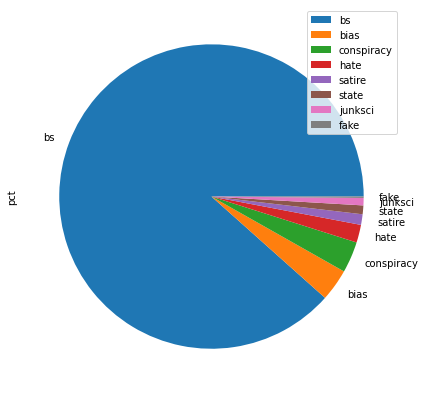

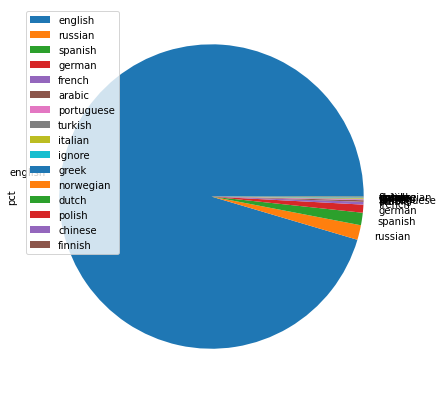

In [98]:
summarize_data(df)

Start data cleaning
Selecting english

Column "language" value distribution english selection

         pct
english  1.0
AxesSubplot(0.135,0.125;0.755x0.755)


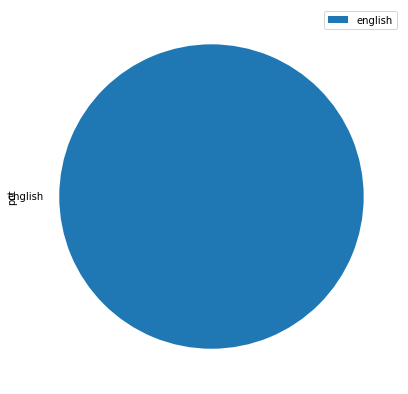

In [99]:
df = strip_lang(df, 'english', plot=True)

In [100]:
cleandf = getCleanData(df, force=False)
cleandf = cleandf.drop('Unnamed: 0', axis=1)

print(cleandf['target'].value_counts())

cleandf = resample(cleandf)
print(cleandf['target'].value_counts())

text_vectorize(cleandf)
print(cleandf[ 'target' ].value_counts())

Getting cleaned data
cleaned.csv exsists, pull from cache
returning
1    10900
0     1503
Name: target, dtype: int64
Original dataset shape Counter({1: 10900, 0: 1503})
Resampled dataset shape Counter({0: 1503, 1: 1503})
1    1503
0    1503
Name: target, dtype: int64


 Top 10 title features : 
                      term       rank
6295      hillary clinton  22.852882
4009         donald trump  19.879696
7644            le gorafi   9.183551
3305           daily wire   7.048161
12703       standing rock   6.613407
15294           world war   5.693479
2463     clinton campaign   4.547508
3386           david duke   4.396383
15026         white house   4.308500
2511   clinton foundation   4.240717
Bypass kmeans for speed


 Top 10 author features : 
                   term       rank
4        activist post  82.000000
164  daniel greenfield  56.000000
352       jason easley  45.000000
573   patrick slattery  24.748737
219         dr patrick  24.748737
555    noreply blogger  21.810286
79  

AxesSubplot(0.125,0.125;0.62x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)


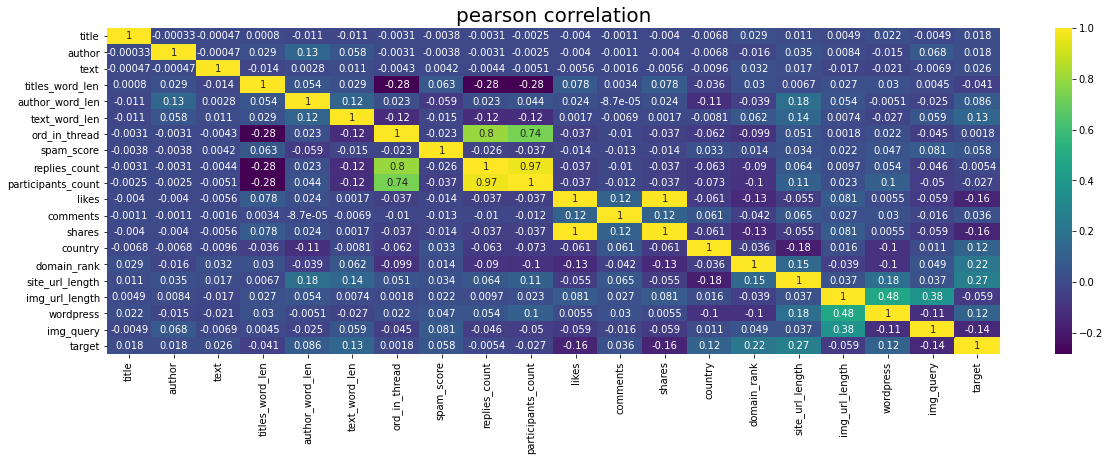

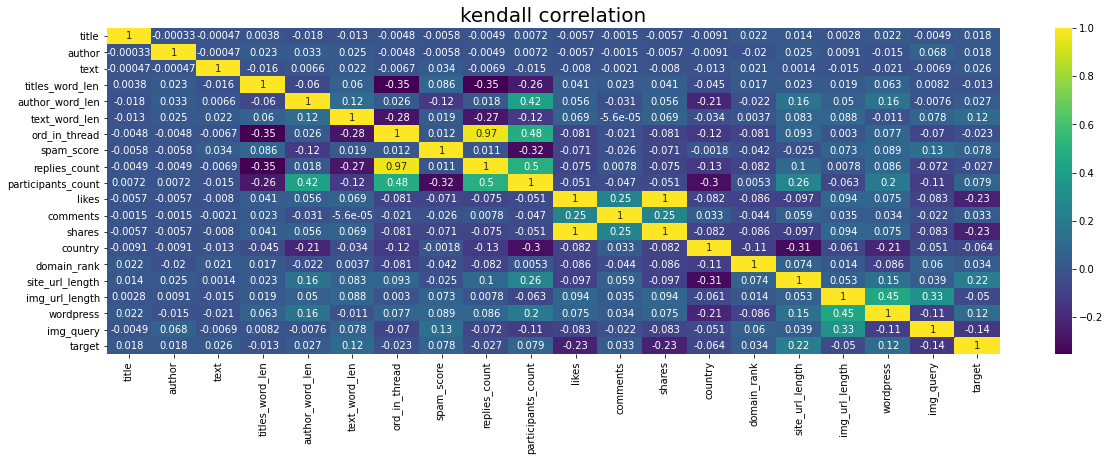

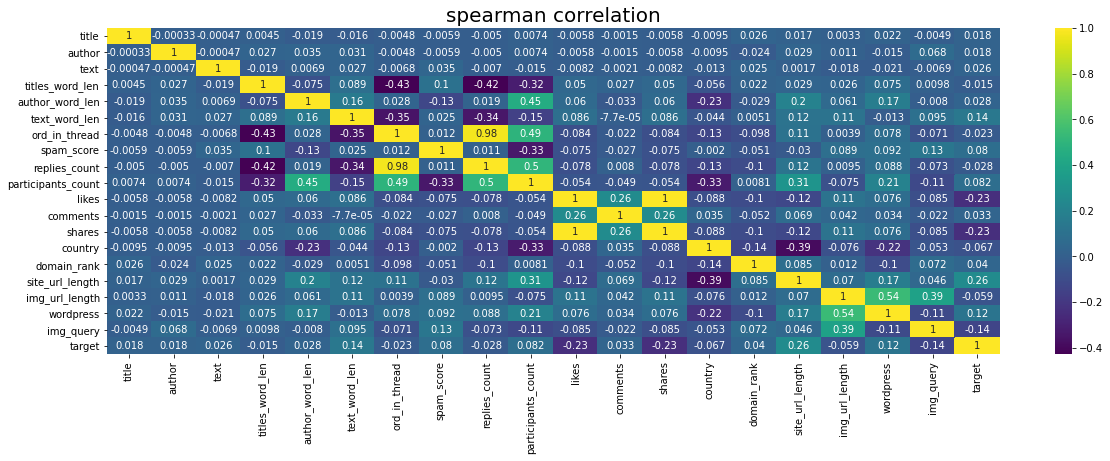

In [101]:
correlate(cleandf)

In [102]:
print(cleandf.columns)

Index(['title', 'author', 'text', 'titles_word_len', 'author_word_len',
       'text_word_len', 'ord_in_thread', 'spam_score', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'country',
       'domain_rank', 'site_url_length', 'img_url_length', 'wordpress',
       'img_query', 'target'],
      dtype='object')


Top 100 features
              Name         Score
0      domain_rank  4.170745e+06
2   img_url_length  2.921825e+02
1  site_url_length  2.741124e+02
4        img_query  5.278109e+01
3        wordpress  2.594305e+01
Running Random Forest
timing: Random Forest 8.64169890499943 seconds
Random Forest estimate accuracy 0.9880265780730897
Building model random_forest
Save True
0    388
1    364
Name: target, dtype: int64


 classifier: random_forest

accuracy:   0.989
confusion matrix:
 [[381   7]
 [  1 363]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       388
           1       0.98      1.00      0.99       364

    accuracy                           0.99       752
   macro avg       0.99      0.99      0.99       752
weighted avg       0.99      0.99      0.99       752

Built model random_forest
Running Gaussian Naive Bayes
timing: Gaussian Naive Bayes 0.03867969400016591 seconds
Gaussian Naive Bayes estimate accuracy 0.63172757475

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Ensemble Acc: 0.9557541528239202
Model evaluation
                           Model     Score
1                  random forest  0.988027
11                 XGB classifie  0.986698
6                            KNN  0.975720
10  gradient boosting classifier  0.975052
3        support vector machines  0.972721
0                       ensemble  0.955754
9           ada boost classifier  0.881573
8   linear discriminant analysis  0.646032
2           gaussian naive bayes  0.631728
5            logistic regression  0.600781
7                     perceptron  0.470050
4              linear regression  0.135976


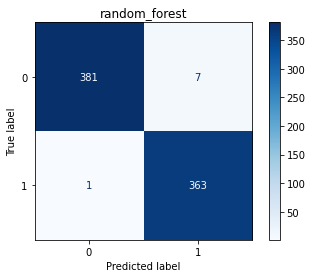

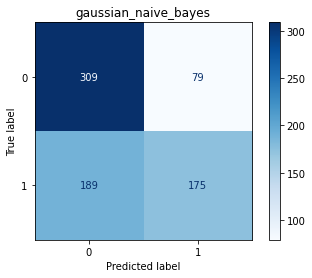

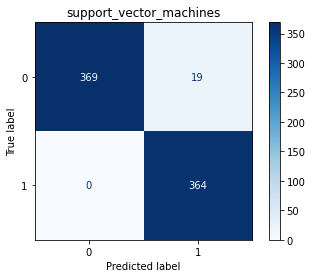

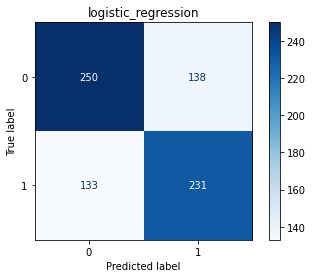

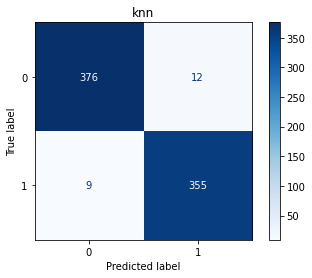

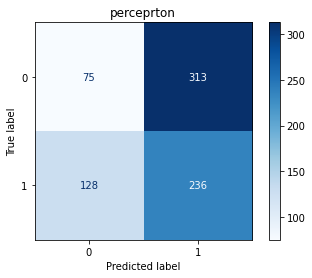

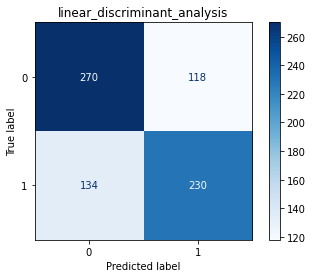

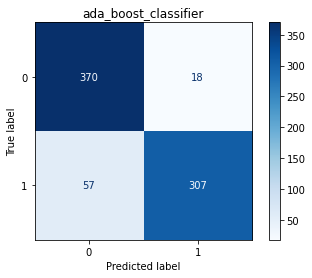

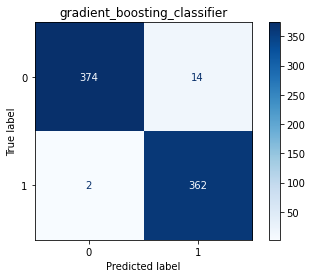

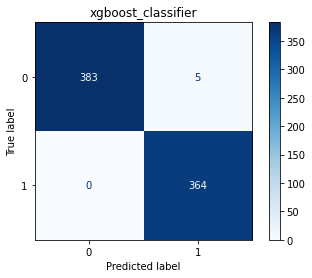

In [103]:
metadata_features = ['domain_rank', 'site_url_length', 'img_url_length', 'wordpress', 'img_query', 'target' ]
classify(cleandf, metadata_features)

Top 100 features
              Name         Score
5    text_word_len  37517.466204
4  author_word_len     22.760520
3  titles_word_len     15.874652
0            title      0.380560
1           author      0.336914
2             text      0.086634
Running Random Forest
timing: Random Forest 12.774396324000008 seconds
Random Forest estimate accuracy 0.618766334440753
Building model random_forest
Save True
0    388
1    364
Name: target, dtype: int64


 classifier: random_forest

accuracy:   0.630
confusion matrix:
 [[241 147]
 [131 233]]
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       388
           1       0.61      0.64      0.63       364

    accuracy                           0.63       752
   macro avg       0.63      0.63      0.63       752
weighted avg       0.63      0.63      0.63       752

Built model random_forest
Running Gaussian Naive Bayes
timing: Gaussian Naive Bayes 0.044347528000798775 seconds
Gaussian Naive Ba

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Ensemble Acc: 0.6097619047619048
Model evaluation
                           Model     Score
10  gradient boosting classifier  0.638722
11                 XGB classifie  0.637062
1                  random forest  0.618766
0                       ensemble  0.609762
3        support vector machines  0.603454
9           ada boost classifier  0.596482
6                            KNN  0.576189
5            logistic regression  0.549575
2           gaussian naive bayes  0.542577
8   linear discriminant analysis  0.539261
7                     perceptron  0.506678
4              linear regression  0.020792


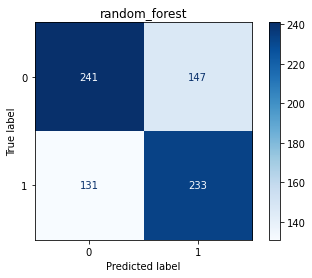

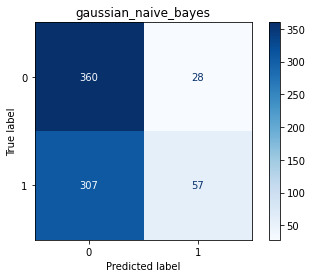

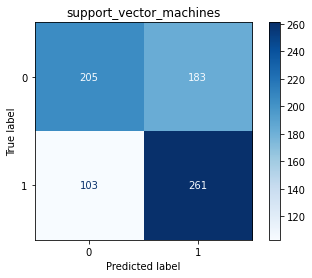

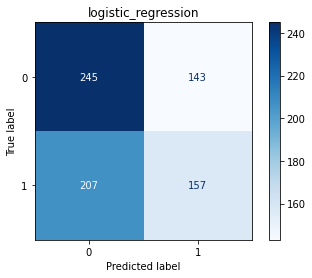

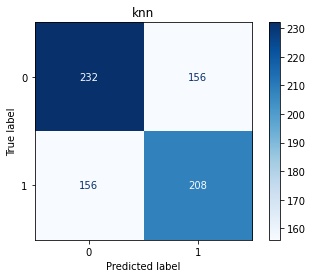

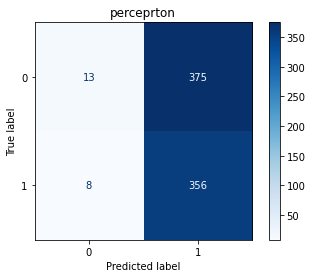

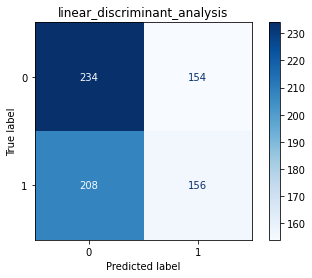

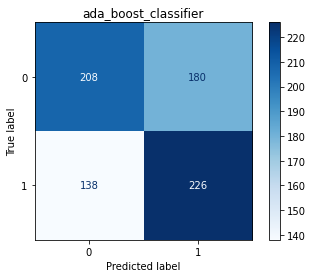

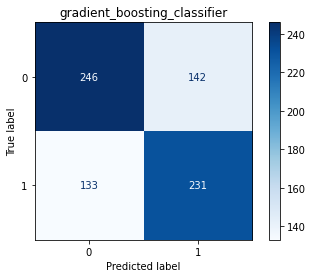

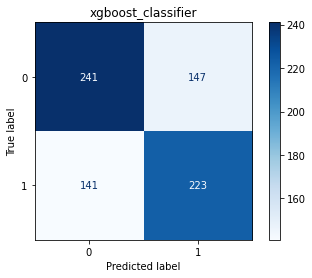

In [104]:
textdata_features = ['title', 'author', 'text', 'titles_word_len', 'author_word_len','text_word_len', 'target']
classify(cleandf, textdata_features)